In [107]:
import csv

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from gensim.models.ldamodel import LdaModel

import re
from nltk.stem.porter import PorterStemmer

import random

In [64]:
def fix_nulls(s):
    for line in s:
        yield line.replace('\0', ' ')

def get_document_durations(fs,j=-2):
    durations = []
    for f in fs:
        csv_f = fix_nulls(open(f,'r'))
        for i,row in enumerate(csv.reader(csv_f)):
            if i==0: continue
            durations.append(int(row[j]))
        csv_f.close()
    return durations

def read_segments(f, min_duration=0, return_dates=False):
    segments = []
    dates = []
    if return_dates:
        dates = []
    csv_f = fix_nulls(open(f,'r'))
    for i,row in enumerate(csv.reader(csv_f)):
        if i==0: continue
        if int(row[6]) > min_duration:
            segments.append(row[7])
            dates.append(row[1])
    csv_f.close()
    if return_dates:
        return segments, dates
    return segments
            

In [59]:
data_dir = "Transcript_Segments"
cnn_f = data_dir + '/CNN_full_segments.csv'
cnn_sample_f = data_dir + '/CNN_sample_segments.csv'
msnbc_f = data_dir + '/MSNBC_full_segments.csv'
msnbc_sample_f = data_dir + '/MSNBC_sample_segments.csv'
fox_f = data_dir + '/FOXNEWS_full_segments.csv'
fox_sample_f = data_dir + '/FOXNEWS_sample_segments.csv'
output_dir = "Figures-EDA"

# Show durations of segments of each network

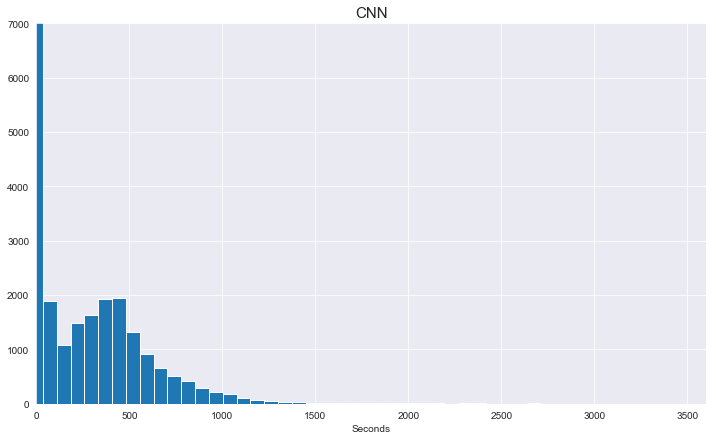

Segments <60s: 8021 segments. They account for 2 % of airtime


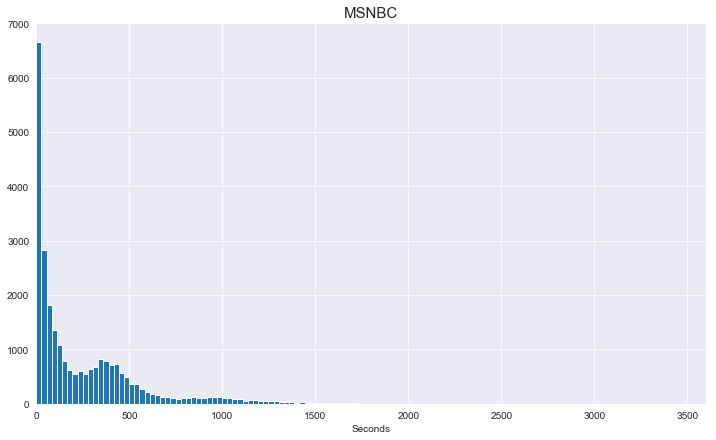

Segments <60s: 9751 segments. They account for 3 % of airtime


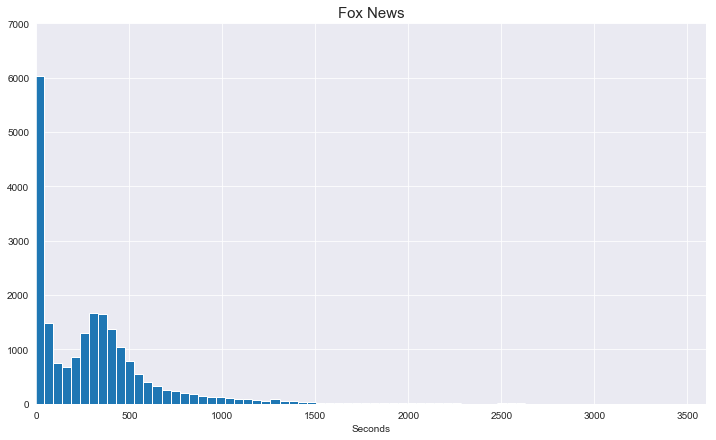

Segments <60s: 6872 segments. They account for 2 % of airtime


In [8]:
def describe_durations(f, c=60, title='', ylim=[], xlim=[]):
    durations = get_document_durations([f])
    plt.figure(figsize=(12,7))
    plt.hist(durations, bins=int(len(durations)**.5))
    plt.title(title, fontsize=15)
    plt.xlabel('Seconds')
    if ylim:
        plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)
    plt.show()
    lt_ = [x for x in durations if x<c]
    print("Segments <{}s:".format(c), len(lt_), 'segments. They account for', round(100*sum(lt_)/sum(durations)), '% of airtime')

describe_durations(cnn_f, title='CNN', ylim=[0,7000], xlim=[0, 60*60])
describe_durations(msnbc_f, title='MSNBC', ylim=[0,7000], xlim=[0, 60*60])
describe_durations(fox_f, title='Fox News', ylim=[0,7000], xlim=[0, 60*60])

# Toy Analysis - Examine Language - Etymology of "Meddling" and "Collusion"

In [42]:
collusion_timeline = {}
meddling_timeline = {}
for label,f in [('CNN', cnn_f), ('Fox News', fox_f), ('MSNBC', msnbc_f)]:
    collusion_timeline[label] = {}
    meddling_timeline[label] = {}
    segments, dates = read_segments(f, return_dates=True)
    count=0
    for i,segment in enumerate(segments):
        segment = segment.lower()
        date = dates[i]
        meddling_occurences = segment.count('meddling') + segment.count('meddle')
        meddling_timeline[label][date] = meddling_timeline[label].get(date,0) + meddling_occurences
        collusion_occurences = segment.count('collusion') + segment.count('collude') + segment.count('colluding')
        collusion_timeline[label][date] = collusion_timeline[label].get(date,0) + collusion_occurences

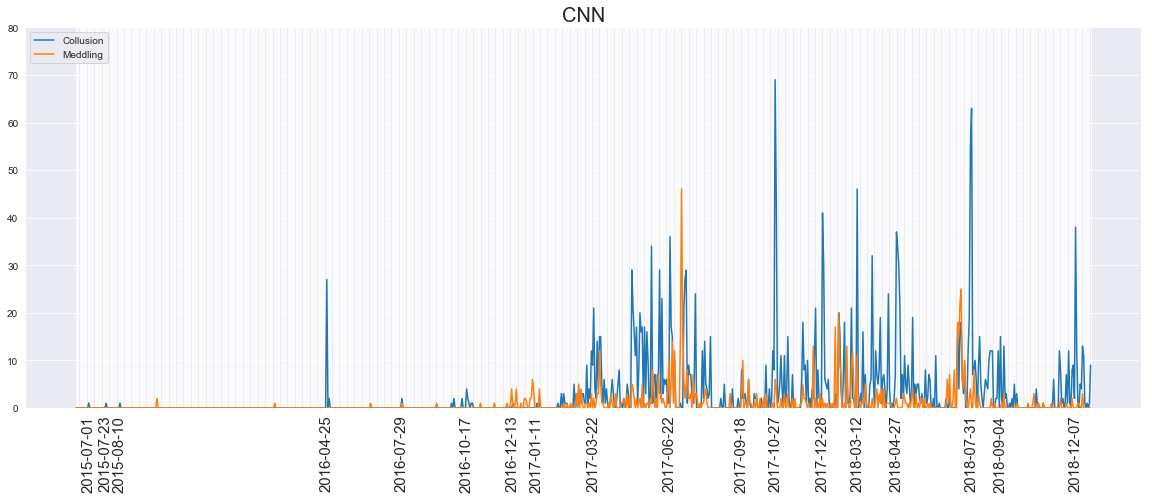

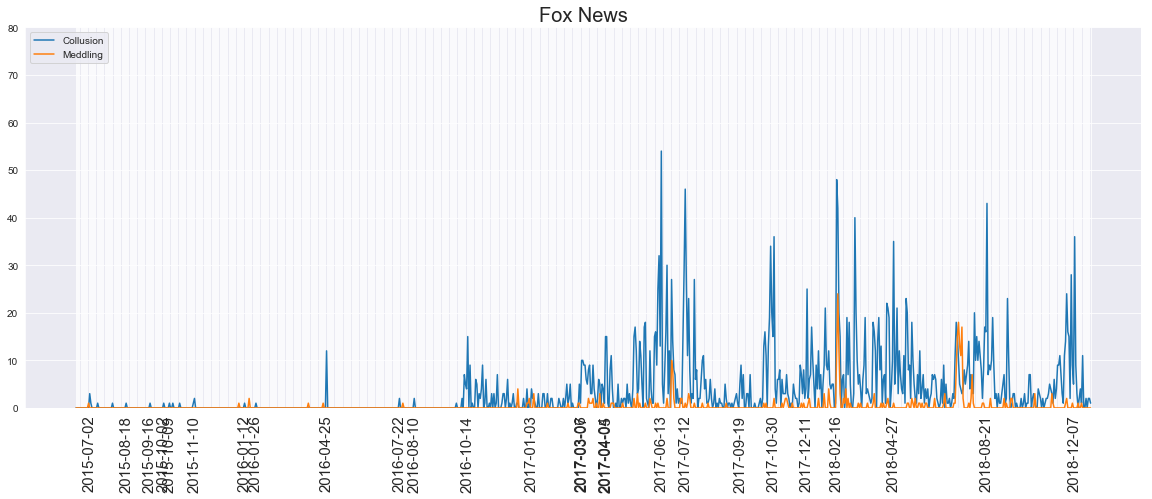

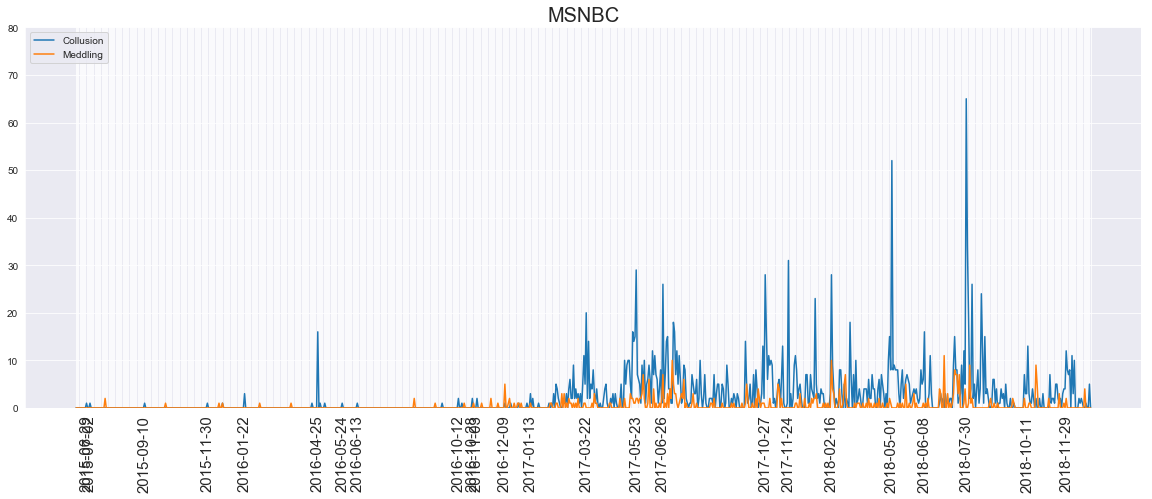

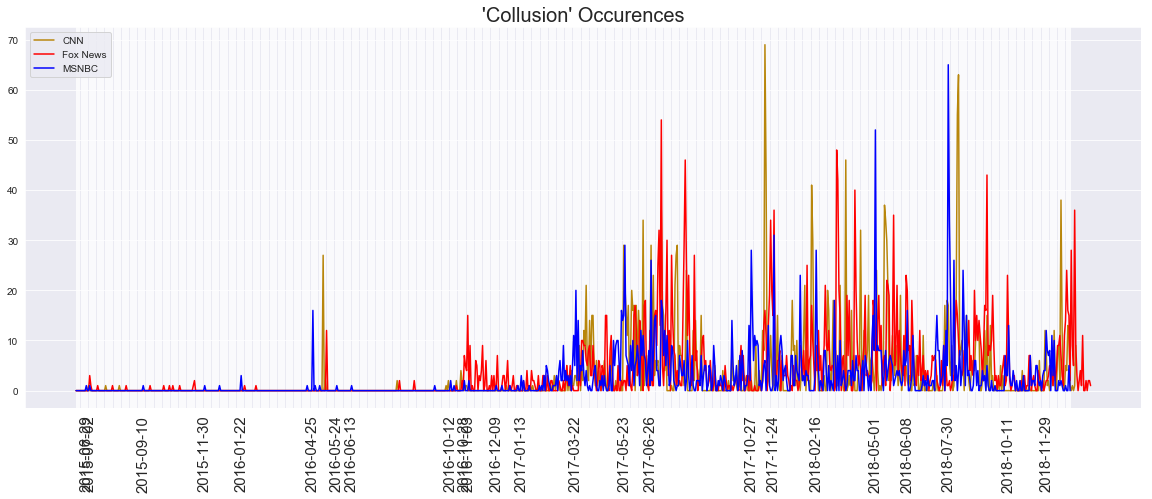

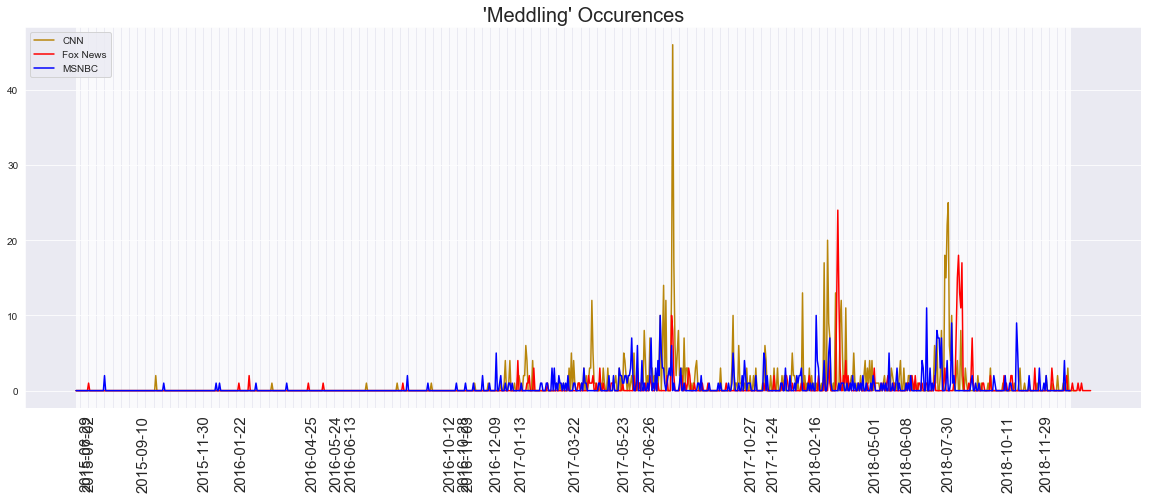

In [55]:
networks = ['CNN', 'Fox News', 'MSNBC']
network_cmap = {
    'CNN': 'darkgoldenrod',
    'Fox News': 'red',
    'MSNBC': 'blue'
}
for network in networks:
    dates, c_counts = map(list, zip(*sorted(collusion_timeline[network].items(), key=lambda x: x[0])))
    dates, m_counts = map(list, zip(*sorted(meddling_timeline[network].items(), key=lambda x: x[0])))
    plt.figure(figsize=(20,7))
    plt.plot(c_counts, label="Collusion")
    plt.plot(m_counts, label='Meddling')
    window = 20
    x_ticks = []
    for i,count in enumerate(c_counts):
        if count == max(c_counts[max(0,i-window):i+window]) and count > 0:
            x_ticks.append(dates[i])
        else:
            x_ticks.append('')
    plt.xticks(range(len(dates)), x_ticks, rotation=90, fontsize=15)
    plt.legend(loc='upper left')
    plt.title(network, fontsize=20)
    plt.ylim([0,80])
    plt.savefig(output_dir + '/{}_collusion_meddling.png'.format(network))
    #plt.show()
plt.figure(figsize=(20,7))
for network in networks:
    dates, counts = map(list, zip(*sorted(collusion_timeline[network].items(), key=lambda x: x[0])))
    plt.plot(counts, label=network, color=network_cmap[network])
window = 20
x_ticks = []
for i,count in enumerate(c_counts):
    if count == max(c_counts[max(0,i-window):i+window]) and count > 0:
        x_ticks.append(dates[i])
    else:
        x_ticks.append('')
plt.xticks(range(len(dates)), x_ticks, rotation=90, fontsize=15)
plt.legend(loc='upper left')
plt.title("'Collusion' Occurences", fontsize=20)
plt.savefig(output_dir+'/Collusion.png')
#plt.show()
plt.figure(figsize=(20,7))
for network in networks:
    dates, counts = map(list, zip(*sorted(meddling_timeline[network].items(), key=lambda x: x[0])))
    plt.plot(counts, label=network, color=network_cmap[network])
window = 20
x_ticks = []
for i,count in enumerate(c_counts):
    if count == max(c_counts[max(0,i-window):i+window]) and count > 0:
        x_ticks.append(dates[i])
    else:
        x_ticks.append('')
plt.xticks(range(len(dates)), x_ticks, rotation=90, fontsize=15)
plt.legend(loc='upper left')
plt.title("'Meddling' Occurences", fontsize=20)
plt.savefig(output_dir+'/Meddling.png')
#plt.show()

# Explore text for topic modelling

In [56]:
# experiment with various cleaning
# look at word frequencies to get an intuitive sense of which words occur with what frequency
# map out a class or plan for encoding corpus information
# find code that exports topics to a spreadsheet

In [173]:
p_stemmer = PorterStemmer()
def clean_for_lda(text):
    text = text.lower()
    no_punctuation = re.sub(r'([^\s\w]|_)+','', text)
    no_2digits = re.sub(r'\s[0-9]{2}', '__number__', no_punctuation)
    no_time = re.sub(r'[0-9]{1,2}:[0-9]{2}','__time__', no_2digits)
    tokens = [p_stemmer.stem(w).strip() for w in no_time.split()]
    return ' '.join(tokens)

def return_word_frequency(list_of_docs, preprocesser= lambda x: x, verbose=False):
    freq_dict = {}
    n = len(list_of_docs)
    for i,doc in enumerate(list_of_docs):
        for token in set(preprocesser(doc).split()):
            freq_dict[token] = freq_dict.get(token,0) + 1
        if verbose and (i%10==0 or i==n-1):
            print("{}% complete".format(round(100*(i+1)/len(list_of_docs), 3)), end='\r')
    return {k:v/n for k,v in freq_dict.items()}

def random_sub_list(l, n):
    if n > len(l):
        print('asked for {} elements, list length = {}'.format(n, len(l)))
        return l
    i_s = random.sample(range(len(l)), n)
    return [l[i] for i in i_s]

In [170]:
key_terms = [
    'trump',
    'clinton',
    'sanders',
    'breaking',
    'news',
    'russia',
    'putin',
    'collusion',
    'mueller',
    'basketball',
    'football',
    'baseball',
    'health',
    'government',
    'opiod',
    'heroin',
    'music',
    'crime',
    'african',
    'european',
    'australian',
    'asia',
    'america',
    'jobs',
    'homeless',
    'economy',
    'stock',
    'finance',
    'wages',
    'unionize',
    'snowflake',
    'transgender',
    'gay',
    'lesbian',
    'sex',
    'sexual',
    'decent',
    'military',
    'war',
    'death'
]

def token_frequency_analysis(docs, key_terms=key_terms, sample_freqs=key_freqs):
    word_freqs = return_word_frequency(docs, preprocesser=clean_for_lda, verbose=True)
    key_terms_dict = {term: word_freqs[p_stemmer.stem(term)] for term in key_terms}
    sample_freq_dict = {}
    for freq in sample_freqs:
        candidates = [(term, df) for term,df in word_freqs.items() if freq+.02>df>freq-.02]
        sample_freq_dict[freq] = random_sub_list(candidates, 4)
    return key_terms_dict, sample_freq_dict

#def report_token_frequency_across_networks(networks_documents, labels):
#    for docs, label in zip(networks_documents, labels)
def display_term_freqs(tf_dict, n=10, top=True):
    i=0
    for t,f in sorted(tf_dict.items(), key=lambda x: x[1], reverse=top):
        print(t,f)
        i+=1
        if i==n: break
        
def zipf(corpi, labels, savefig=''):
    plt.figure(figsize=(10,10))
    for corpus, label in zip(corpi,labels):
        d = {}
        N = 0
        for term in corpus.split():
            d[term] = d.get(term,0) + 1
            N+=1
        ranks, freqs = zip(*[(i+1, t_f[1]/N) for i, t_f in enumerate(sorted(d.items(), key=lambda x: x[1], reverse=True))])
        plt.plot(ranks, freqs, label=label)
        plt.yscale('log')
        plt.xscale('log')
    plt.title("Zipf's Law on Cable News Transcripts", fontsize=20)
    plt.xlabel('Rank', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.legend(loc = 'upper right')
    if savefig:
        plt.savefig(savefig)
    plt.show()

CNN
Fox News
MSNBC


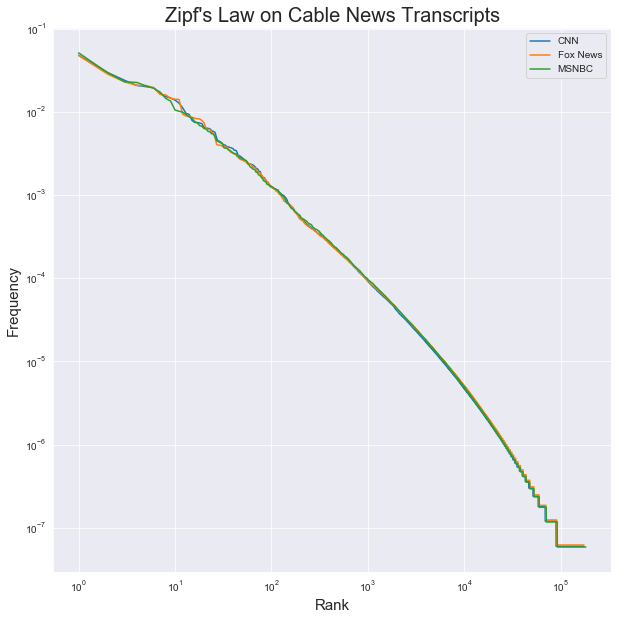

In [171]:
zipf([
    ' '.join(read_segments(cnn_f)), 
    ' '.join(read_segments(fox_f)), 
    ' '.join(read_segments(msnbc_f))], 
    ['CNN', 'Fox News', 'MSNBC'], savefig=output_dir+'/zipf_plot.png')

In [135]:
all_cnn_segs = read_segments(cnn_f, min_duration=60)
all_fox_segs = read_segments(fox_f, min_duration=60)
all_msnbc_segs = read_segments(msnbc_f, min_duration=60)
c_key_terms_dict, c_sample_freq_dict = token_frequency_analysis(all_cnn_segs)
m_key_terms_dict, m_sample_freq_dict = token_frequency_analysis(all_msnbc_segs)
f_key_terms_dict, f_sample_freq_dict = token_frequency_analysis(all_fox_segs)


In [142]:
rows = [["", "CNN", "Fox News", "MSNBC"]]
for term, freq in c_key_terms_dict.items():
    rows.append([term, freq, f_key_terms_dict[term], m_key_terms_dict[term]])

In [143]:
for freq, c_terms in c_sample_freq_dict.items():
    f_terms = f_sample_freq_dict[freq]
    m_terms = m_sample_freq_dict[freq]
    for i,term in enumerate(c_terms):
        rows.append([freq, term, f_terms[i], m_terms[i]])

In [144]:
with open(output_dir + '/segment_term_frequency.csv','w') as csv_f:
    csv.writer(csv_f).writerows(rows)

# Sample Topic Model

In [206]:
cnn_sample_segs = read_segments(cnn_sample_f, min_duration=60)
fox_sample_segs = read_segments(fox_sample_f, min_duration=60)
msnbc_sample_segs = read_segments(msnbc_sample_f, min_duration=60)

In [205]:
def build_gensim_bow(text, vocab):
    id_count_dict = {}
    tokens = text.split(' ')
    for token in tokens:
        if token in vocab: # if it's one of our vocabulary
            id_count_dict[vocab[token]] = id_count_dict.get(vocab[token], 0) + 1
    return sorted(id_count_dict.items(), key=lambda x: x[0])

def build_vocabulary(docs, preprocessor, min_df, max_df):
    term_to_index = {}
    index_to_term = {}
    # make dict of term df from docs. extract terms that meet frequency constraints
    term_df_dict = return_word_frequency(docs, preprocesser=preprocessor, verbose=True)
    i=0
    for term, df in sorted(term_df_dict.items(), key=lambda x: x[1], reverse=True):
        if df < max_df and df*len(docs)> min_df:
            term_to_index[term] = i
            index_to_term[i] = term
            i+=1
    return [term_to_index, index_to_term]
def train_lda(docs, preprocessor=clean_for_lda, min_df=10, max_df=.7, n_topics=10):
    term_to_index, index_to_term = build_vocabulary(docs, preprocessor, min_df, max_df)
    gensim_corpus = list(filter(lambda x: x, [build_gensim_bow(clean_for_lda(doc), term_to_index) for doc in docs]))
    print("Training Model. {} documents. Vocabulary Size = {}".format(len(docs), len(term_to_index)))
    model = LdaModel(corpus=gensim_corpus, num_topics=n_topics, alpha='auto', chunksize=100)
    return model, term_to_index, index_to_term

def save_learned_topics(model, index_to_term, f):
    rows = [["Topic Name", "Topic ID", "Words..."]]
    for topic, _ in model.show_topics(num_topics=-1):
        row = ['', topic]
        for term_id, score in model.get_topic_terms(topic, topn=40):
            row.append(index_to_term[term_id])
        rows.append(row)
    with open(f,'w') as csv_f:
        csv.writer(csv_f).writerows(rows)

In [203]:
sample_cnn_model, term_to_index, index_to_term = train_lda(cnn_sample_segs,min_df=30)

Training Model. 1422 documents. Vocabulary Size = 2191


In [207]:
all_sample_segs = cnn_sample_segs + fox_sample_segs + msnbc_sample_segs
all_sample_model, term_to_index, index_to_term = train_lda(all_sample_segs,min_df=50, n_topics=20)
save_learned_topics(all_sample_model, index_to_term, 'Topic-Modelling/all_sample_model.csv')

Training Model. 3899 documents. Vocabulary Size = 3171


In [210]:
cnn_full_model, term_to_index, index_to_term = train_lda(all_cnn_segs,min_df=50, max_df=.6, n_topics=13)
save_learned_topics(cnn_full_model, index_to_term, 'Topic-Modelling/cnn_full_model_k=13.csv')

Training Model. 13936 documents. Vocabulary Size = 5900
